In [1]:
# data driven packages
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import ImageColor

# plotting packages
import umap
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import plotnine
from plotnine import *

# cluster packages
from kmodes.kprototypes import KPrototypes

# use importance plot
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

# file copy-arrange
import shutil

작업 경로 설정
데이터 불러오기

In [2]:
os.chdir(r'C:\Users\styli\Desktop\데청캠 미니 프로젝트 -OneStore_webtoon_img_cluster-main')
data = pd.read_csv('webtoon_top5col.csv')

데이터 형태 확인

In [3]:
data.head()

,제목,카테고리,hex1,hex2,hex3,hex4,hex5,hex1rate,hex2rate,hex3rate,hex4rate,hex5rate,file_path
0,4와 2분의 1 정거장,BL,#fefcf7,#fcd2cf,#fa8263,#f6ae9d,#dd3435,0.362742,0.254111,0.181476,0.106669,0.095002,4와 2분의 1 정거장.jpg
1,BL의 정석,BL,#e5e8e9,#3294c2,#282b2e,#6a6f73,#b6b7b9,0.595297,0.128252,0.106436,0.085562,0.084453,BL의 정석.jpg
2,Not so bad(낫 소 배드),BL,#fdf6f1,#301632,#f3d9c4,#693560,#b68293,0.538033,0.174916,0.169953,0.064639,0.052458,Not so bad(낫 소 배드).jpg
3,Take on Me,BL,#f2f5f1,#f0c9c2,#d4898d,#914a5d,#431c27,0.550254,0.149492,0.129461,0.092122,0.078671,Take on Me.jpg
4,[BL] 새비지 가든 [일반판],BL,#fdf8f0,#65504d,#a39796,#e1c3ae,#251916,0.323965,0.282766,0.149054,0.134914,0.109301,[BL] 새비지 가든 [일반판].jpg


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   제목         1107 non-null   object 
 1   카테고리       1107 non-null   object 
 2   hex1       1107 non-null   object 
 3   hex2       1107 non-null   object 
 4   hex3       1107 non-null   object 
 5   hex4       1107 non-null   object 
 6   hex5       1107 non-null   object 
 7   hex1rate   1107 non-null   float64
 8   hex2rate   1107 non-null   float64
 9   hex3rate   1107 non-null   float64
 10  hex4rate   1107 non-null   float64
 11  hex5rate   1107 non-null   float64
 12  file_path  1107 non-null   object 
dtypes: float64(5), object(8)
memory usage: 112.6+ KB


hex1 ~ hex5는 색깔 분포의 순위를 의미하고
hex1rate는 해당번째 순위의 정도를 의미하고 있다.

NN은 비지도 학습에 좋지 못하므로 제외
카테고리는 범주형 자료이니 군집화시 유의
hexcode는 rgb형으로 바꾸어 분석을 실시하여야 할 것.

RGB형은 다음과 같이 변형이 가능하다.

In [5]:
print(f'hex code : {data.hex1[0]} , rgb : {ImageColor.getcolor(data.hex1[0], "RGB")} ')
a, b, c = ImageColor.getcolor(data.hex1[0], "RGB")
print(f'정규화 rgb : {a/255, b/255, c/255}')

hex code : #fefcf7 , rgb : (254, 252, 247) 
정규화 rgb : (0.996078431372549, 0.9882352941176471, 0.9686274509803922)


혹은 다음과 같이 변형이 가능하다.
사실 to_rgb는 모르는 사용법이라 한번 결과체크하는 과정때문에 사용함.

k-mean 과정에는 스케일링을 같게 해주는 과정이 필요하므로, 이 변환이 더 올바르다고 판단하였다.

In [6]:
to_rgb(data.hex1[0])

(0.996078431372549, 0.9882352941176471, 0.9686274509803922)

비효율적이긴 한데 효율적인 생각이 바로 안나니까, 그냥 이대로 구현함.

In [7]:
hex1 = np.array([to_rgb(line) for line in data.hex1])
hex2 = np.array([to_rgb(line) for line in data.hex2])
hex3 = np.array([to_rgb(line) for line in data.hex3])
hex4 = np.array([to_rgb(line) for line in data.hex4])
hex5 = np.array([to_rgb(line) for line in data.hex5])

In [8]:
hex_arr = np.concatenate((hex1, hex2, hex3, hex4, hex5),axis=1)

In [9]:
hex_arr[:5]

array([[0.99607843, 0.98823529, 0.96862745, 0.98823529, 0.82352941,
        0.81176471, 0.98039216, 0.50980392, 0.38823529, 0.96470588,
        0.68235294, 0.61568627, 0.86666667, 0.20392157, 0.20784314],
       [0.89803922, 0.90980392, 0.91372549, 0.19607843, 0.58039216,
        0.76078431, 0.15686275, 0.16862745, 0.18039216, 0.41568627,
        0.43529412, 0.45098039, 0.71372549, 0.71764706, 0.7254902 ],
       [0.99215686, 0.96470588, 0.94509804, 0.18823529, 0.08627451,
        0.19607843, 0.95294118, 0.85098039, 0.76862745, 0.41176471,
        0.20784314, 0.37647059, 0.71372549, 0.50980392, 0.57647059],
       [0.94901961, 0.96078431, 0.94509804, 0.94117647, 0.78823529,
        0.76078431, 0.83137255, 0.5372549 , 0.55294118, 0.56862745,
        0.29019608, 0.36470588, 0.2627451 , 0.10980392, 0.15294118],
       [0.99215686, 0.97254902, 0.94117647, 0.39607843, 0.31372549,
        0.30196078, 0.63921569, 0.59215686, 0.58823529, 0.88235294,
        0.76470588, 0.68235294, 0.14509804, 

In [10]:
rgb_col_lab = ['hex1R', 'hex1G', 'hex1B', 'hex2R', 'hex2G', 'hex2B', 'hex3R', 'hex3G', 'hex3B',
               'hex4R', 'hex4G', 'hex4B', 'hex5R', 'hex5G', 'hex5B']
rgb_data = pd.DataFrame(hex_arr, columns = rgb_col_lab)

RGB 값 변화한 데이터를, data에 결합해준다.
이하 데이터셋을 분석 기본 세트로 정의함.

In [11]:
rgb_data.head()

,hex1R,hex1G,hex1B,hex2R,hex2G,hex2B,hex3R,hex3G,hex3B,hex4R,hex4G,hex4B,hex5R,hex5G,hex5B
0,0.996078,0.988235,0.968627,0.988235,0.823529,0.811765,0.980392,0.509804,0.388235,0.964706,0.682353,0.615686,0.866667,0.203922,0.207843
1,0.898039,0.909804,0.913725,0.196078,0.580392,0.760784,0.156863,0.168627,0.180392,0.415686,0.435294,0.450980,0.713725,0.717647,0.725490
2,0.992157,0.964706,0.945098,0.188235,0.086275,0.196078,0.952941,0.850980,0.768627,0.411765,0.207843,0.376471,0.713725,0.509804,0.576471
3,0.949020,0.960784,0.945098,0.941176,0.788235,0.760784,0.831373,0.537255,0.552941,0.568627,0.290196,0.364706,0.262745,0.109804,0.152941
4,0.992157,0.972549,0.941176,0.396078,0.313725,0.301961,0.639216,0.592157,0.588235,0.882353,0.764706,0.682353,0.145098,0.098039,0.086275


In [12]:
data = pd.concat([data, rgb_data], axis = 1)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 28 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   제목         1107 non-null   object 
 1   카테고리       1107 non-null   object 
 2   hex1       1107 non-null   object 
 3   hex2       1107 non-null   object 
 4   hex3       1107 non-null   object 
 5   hex4       1107 non-null   object 
 6   hex5       1107 non-null   object 
 7   hex1rate   1107 non-null   float64
 8   hex2rate   1107 non-null   float64
 9   hex3rate   1107 non-null   float64
 10  hex4rate   1107 non-null   float64
 11  hex5rate   1107 non-null   float64
 12  file_path  1107 non-null   object 
 13  hex1R      1107 non-null   float64
 14  hex1G      1107 non-null   float64
 15  hex1B      1107 non-null   float64
 16  hex2R      1107 non-null   float64
 17  hex2G      1107 non-null   float64
 18  hex2B      1107 non-null   float64
 19  hex3R      1107 non-null   float64
 20  hex3G   

In [14]:
data.head()

,제목,카테고리,hex1,hex2,hex3,hex4,hex5,hex1rate,hex2rate,hex3rate,...,hex2B,hex3R,hex3G,hex3B,hex4R,hex4G,hex4B,hex5R,hex5G,hex5B
0,4와 2분의 1 정거장,BL,#fefcf7,#fcd2cf,#fa8263,#f6ae9d,#dd3435,0.362742,0.254111,0.181476,...,0.811765,0.980392,0.509804,0.388235,0.964706,0.682353,0.615686,0.866667,0.203922,0.207843
1,BL의 정석,BL,#e5e8e9,#3294c2,#282b2e,#6a6f73,#b6b7b9,0.595297,0.128252,0.106436,...,0.760784,0.156863,0.168627,0.180392,0.415686,0.435294,0.450980,0.713725,0.717647,0.725490
2,Not so bad(낫 소 배드),BL,#fdf6f1,#301632,#f3d9c4,#693560,#b68293,0.538033,0.174916,0.169953,...,0.196078,0.952941,0.850980,0.768627,0.411765,0.207843,0.376471,0.713725,0.509804,0.576471
3,Take on Me,BL,#f2f5f1,#f0c9c2,#d4898d,#914a5d,#431c27,0.550254,0.149492,0.129461,...,0.760784,0.831373,0.537255,0.552941,0.568627,0.290196,0.364706,0.262745,0.109804,0.152941
4,[BL] 새비지 가든 [일반판],BL,#fdf8f0,#65504d,#a39796,#e1c3ae,#251916,0.323965,0.282766,0.149054,...,0.301961,0.639216,0.592157,0.588235,0.882353,0.764706,0.682353,0.145098,0.098039,0.086275


데이터셋의 형태도 그대로 유지되었고
표준화 완료된 값으로 RGB 값을 반환하였다.

일단 가능한지 보기 위해. 카테고리, hex1-5(rgb값), hex1-5 rate를 k-prototype에 적용시킨다.

카테고리 함수 하나 때문에 UMAP을 사용했기 때문에, 그래프는 매 실행마다 다르게 나온다. 막으려먼, fit, umap 등에서 모두 seed 고정하고
random.seed, np.seed, tf.seed의 고정도 필요.

## 차후에 확인 작업 필요하다. rgb값만 넣고 k-prototype 돌린결과가 더 양호한지, 3개의 색만 넣은게 양호한지. 등등 여러가지 경우의 수를 확인해야 한다.

In [15]:
protodata = data.drop(['제목','hex1','hex2','hex3','hex4','hex5','file_path','hex1rate','hex2rate','hex3rate','hex4rate','hex5rate'],axis = 1)
protodata.head()

,카테고리,hex1R,hex1G,hex1B,hex2R,hex2G,hex2B,hex3R,hex3G,hex3B,hex4R,hex4G,hex4B,hex5R,hex5G,hex5B
0,BL,0.996078,0.988235,0.968627,0.988235,0.823529,0.811765,0.980392,0.509804,0.388235,0.964706,0.682353,0.615686,0.866667,0.203922,0.207843
1,BL,0.898039,0.909804,0.913725,0.196078,0.580392,0.760784,0.156863,0.168627,0.180392,0.415686,0.435294,0.450980,0.713725,0.717647,0.725490
2,BL,0.992157,0.964706,0.945098,0.188235,0.086275,0.196078,0.952941,0.850980,0.768627,0.411765,0.207843,0.376471,0.713725,0.509804,0.576471
3,BL,0.949020,0.960784,0.945098,0.941176,0.788235,0.760784,0.831373,0.537255,0.552941,0.568627,0.290196,0.364706,0.262745,0.109804,0.152941
4,BL,0.992157,0.972549,0.941176,0.396078,0.313725,0.301961,0.639216,0.592157,0.588235,0.882353,0.764706,0.682353,0.145098,0.098039,0.086275


k-prototype은 카테고리는 object형, 수치형은 k-mean 기반이기에 표준화가 이뤄져야한다.
본 코드에서는 정규화로 계산되었다.

In [16]:
protodata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   카테고리    1107 non-null   object 
 1   hex1R   1107 non-null   float64
 2   hex1G   1107 non-null   float64
 3   hex1B   1107 non-null   float64
 4   hex2R   1107 non-null   float64
 5   hex2G   1107 non-null   float64
 6   hex2B   1107 non-null   float64
 7   hex3R   1107 non-null   float64
 8   hex3G   1107 non-null   float64
 9   hex3B   1107 non-null   float64
 10  hex4R   1107 non-null   float64
 11  hex4G   1107 non-null   float64
 12  hex4B   1107 non-null   float64
 13  hex5R   1107 non-null   float64
 14  hex5G   1107 non-null   float64
 15  hex5B   1107 non-null   float64
dtypes: float64(15), object(1)
memory usage: 138.5+ KB


UMAP Embedding 작업.
numerical의 전처리는 이미 정규화 되었기에 실시하지 않는다.

In [17]:
#Preprocessing numerical
numerical = protodata.select_dtypes(exclude='object')

##preprocessing categorical
categorical = protodata.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(protodata.select_dtypes(include='object').columns) / protodata.shape[1]
print(f'전체에서 범주형 데이터 비중 : {categorical_weight}')

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)

전체에서 범주형 데이터 비중 : 0.0625


C:\Users\styli\anaconda3\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable


임베딩 후 그래프 그리기.

In [18]:
#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)

embedding = umap.umap_.simplicial_set_embedding(data=fit1._raw_data, graph=intersection, n_components=fit1.n_components,
                                                initial_alpha=fit1._initial_alpha, a=fit1._a, b=fit1._b,
                                                gamma=fit1.repulsion_strength, negative_sample_rate=fit1.negative_sample_rate,
                                                n_epochs=500, init = 'random', random_state = np.random, metric = fit1.metric,
                                                metric_kwds= fit1._metric_kwds, densmap = False, densmap_kwds=False, output_dens=False, verbose=1)

  0%|          | 0/500 [00:00<?, ?it/s]

플롯을 출력한다

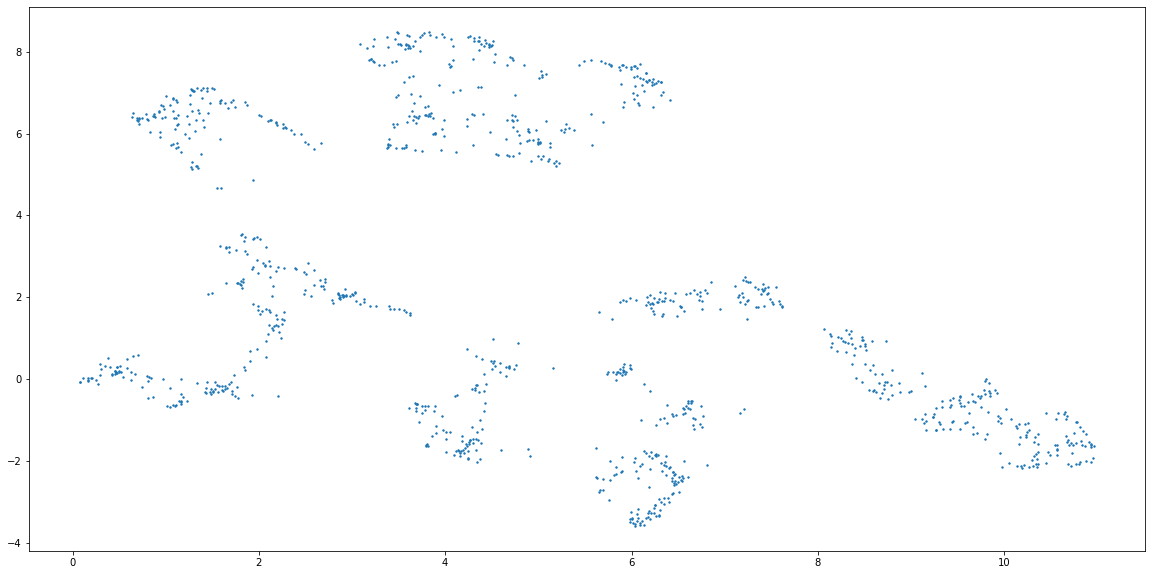

In [19]:
plt.figure(figsize=(20, 10))
plt.scatter(embedding[0][:, 0], embedding[0][:, 1],s=2, cmap='Spectral', alpha=1.0)
plt.show()

좋은 모양일까?, 좋은 모양이더라도 UMAP이기에 항상 이모양이라고 가정할 수 없기 때문에 잘 모른다.
또한 클러스터링 된 결과가 그래프의 모양과 일치하지 않을수도 있다.


일단 그래프 작업은 여기까지 진행하고, prototype을 돌리기 위한 사전작업을 진행한다.

In [20]:
categorical_columns = [protodata.columns.get_loc(col) for col in list(protodata.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(protodata.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(categorical_columns))

Categorical columns           : ['카테고리']
Categorical columns position  : [0]


원래라면, k=8정도에서 멈출것이지만, 열이 상당히 많음으로
또한 분류 해야할 범위가 크다고 판단하여, 16까지 진행하였다.

또한 scree plot은 결과를 고정하는것이 좋으므로 seed를 임의로 고정하여 그렸다.

In [21]:
# Choose optimal K using Elbow method
cost = []
for cluster in tqdm(range(1, 17)):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 404, verbose = 1)
        kprototype.fit_predict(protodata, categorical = categorical_columns)
        cost.append(kprototype.cost_)
        print(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

  0%|          | 0/16 [00:00<?, ?it/s]exception calling callback for <Future at 0x211e6c0cd00 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "C:\Users\styli\anaconda3\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "C:\Users\styli\anaconda3\lib\site-packages\joblib\parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "C:\Users\styli\anaconda3\lib\site-packages\joblib\parallel.py", line 794, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "C:\Users\styli\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\styli\anaconda3\lib\site-packages\joblib\parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\styli\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 531, in apply_async
    future = sel

k=2~20 까지의 비용함수 그래프를 그린다. -> scree plot

In [ ]:
df_cost = pd.DataFrame({'Cluster':range(1, 17), 'Cost':cost})
# Data viz
plotnine.options.figure_size = (10, 5)
(
        ggplot(data = df_cost)+
        geom_line(aes(x = 'Cluster',
                      y = 'Cost'))+
        geom_point(aes(x = 'Cluster',
                       y = 'Cost'))+
        geom_label(aes(x = 'Cluster',
                       y = 'Cost',
                       label = 'Cluster'),
                   size = 10,
                   nudge_y = 1000) +
        labs(title = 'Optimal number of cluster with Elbow Method')+
        xlab('Number of Clusters k')+
        ylab('Cost')+
        theme_minimal()
)

4가 기준점으로 삼기 적절한것 같은 판단 하에, 4로 군집화를 시도하였다.
모양이 올바르지 않거나, 군집화가 안맞으면 바꾸는게 맞다고 판단.

In [ ]:
# k 기준값
k_cluster = 7
# clustering process
kproto = KPrototypes(n_clusters= k_cluster, init='Cao', n_jobs = -1)
clusters = kproto.fit_predict(protodata, categorical=categorical_columns)

범주에 할당된 값은 다음과 같습니다.

In [ ]:
pd.Series(clusters).value_counts()

그래프 상에서는 다음과 같이 나타납니다.

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[0][:, 0], embedding[0][:, 1], s=12, c=clusters, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=k_cluster),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

구성값을 좀 파악해보고 싶은데. 일단 원 데이터 셋에, 분류된 라벨링 값을 부여함.

In [ ]:
outputs = data.copy()
outputs['Cluster Labels'] = kproto.labels_

사실 이렇게 봐서는 잘 모르겠다....

In [ ]:
outputs[outputs['Cluster Labels']==0].카테고리.value_counts()

In [ ]:
outputs[outputs['Cluster Labels']==0].hex1.unique()

아니 진짜로... 진짜 모르겠으니까 폴더별로 정리해서 그림 묶음 확인하자.
여기서부터는 실행 안한 코드라서 잘 돌아가는지 모름.

In [ ]:
# 기존 작업에서 실시하였다면,
# 기존에 존재하는 값또한 지워야 하기 때문에, os.rmdir을 사용하지 못합니다.
if os.path.exists('KPrototypes_Output_images'):
    shutil.rmtree('KPrototypes_Output_images')

# 다시 폴더를 만들어줍니다.
os.mkdir('KPrototypes_Output_images')
for i in range(k_cluster):
    os.mkdir('KPrototypes_Output_images/'+str(i)+'_cluster')

폴더를 만들었으니, 이제 해당하는 위치에, 파일을 집어넣기만 하면 된다.
앞서 그림 색상에서, path를 포함하는 k-mean 파일을 새로 만들었으므로, 그 위치 참조.

아래 코드로 클러스터 폴더에 복사-저장되어 정리되겠다.

In [ ]:
for idx in tqdm(outputs.index):
    line = outputs.loc[idx]
    # 복사할 파일의 위치 - 상대경로.
    file_from = str(line.카테고리) + '/' + str(line.file_path)
    # 도착위치.
    file_to = 'KPrototypes_Output_images/' + str(line['Cluster Labels']) +'_cluster/' +str(line.file_path)

    shutil.copyfile(file_from, file_to)

센트로이드 중심점.

In [ ]:
# Cluster centorid
kproto.cluster_centroids_

In [ ]:
cent = pd.DataFrame(kproto.cluster_centroids_)

cent = pd.concat([(cent.iloc[:,0:3].astype('float')*255).round().astype('int'),(cent.iloc[:,3:6].astype('float')*255).round().astype('int'),
                  (cent.iloc[:,6:9].astype('float')*255).round().astype('int'),(cent.iloc[:,9:12].astype('float')*255).round().astype('int'),
                  (cent.iloc[:,12:15].astype('float')*255).round().astype('int')], axis = 1)

cent = cent.to_numpy()

hex1c = []
hex2c = []
hex3c = []
hex4c = []
hex5c = []
for i in range(k_cluster):
    hex1c.append(tuple(cent[i,0:3]))
    hex2c.append(tuple(cent[i,3:6]))
    hex3c.append(tuple(cent[i,6:9]))
    hex4c.append(tuple(cent[i,9:12]))
    hex5c.append(tuple(cent[i,12:15]))

cent = pd.DataFrame([hex1c,hex2c,hex3c,hex4c,hex5c])
cent = cent.T
# 이 형태가, 상위 5개 색상의 데이터인것이지.
cent


센트로이드 중심값은 다음과 같이 학습되었다.

In [ ]:
for i in range(cent.shape[0]):
    rgb_list = list(cent.iloc[i])
    one_px = np.array(rgb_list)[np.newaxis, :, :]

    plt.imshow(np.array(one_px));
    plt.axis('off');
    plt.show();

고장났니? 아닌데...

In [ ]:
rgb_list = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
one_px = np.array(rgb_list)[np.newaxis, :, :]

plt.imshow(np.array(one_px));
plt.axis('off');
plt.show();